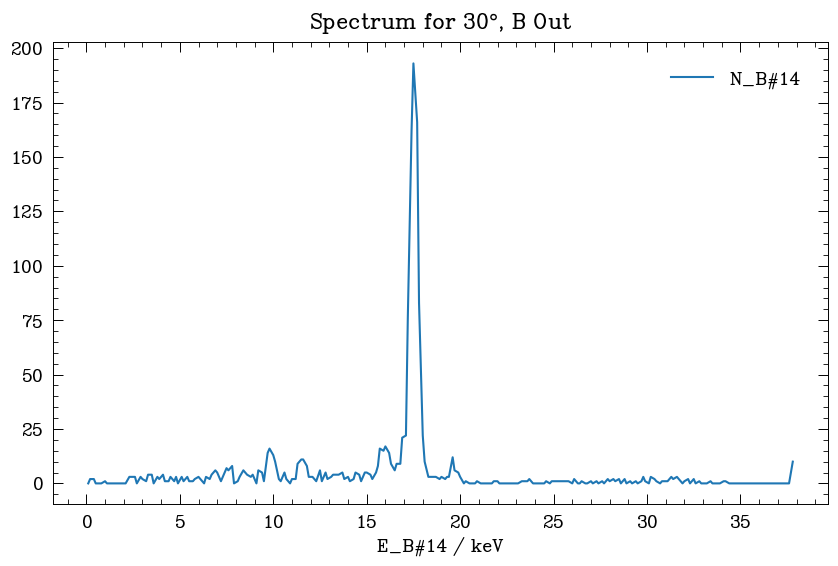

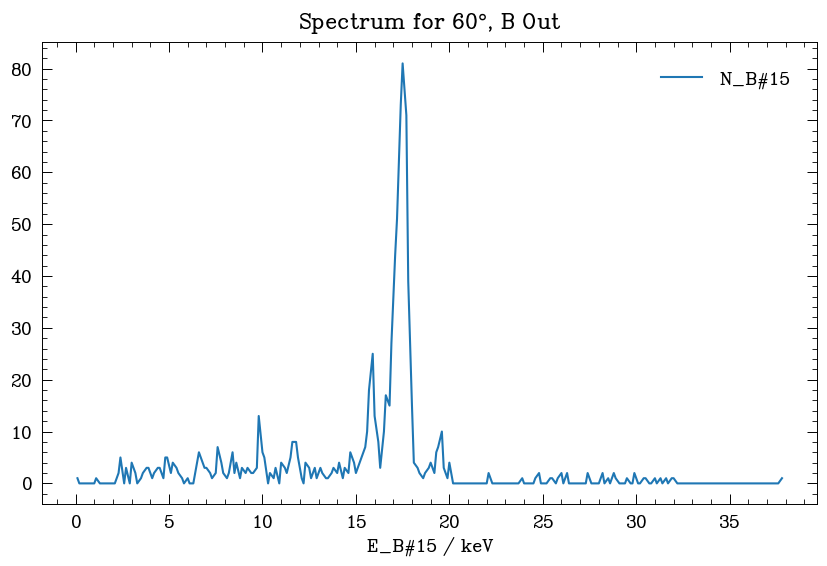

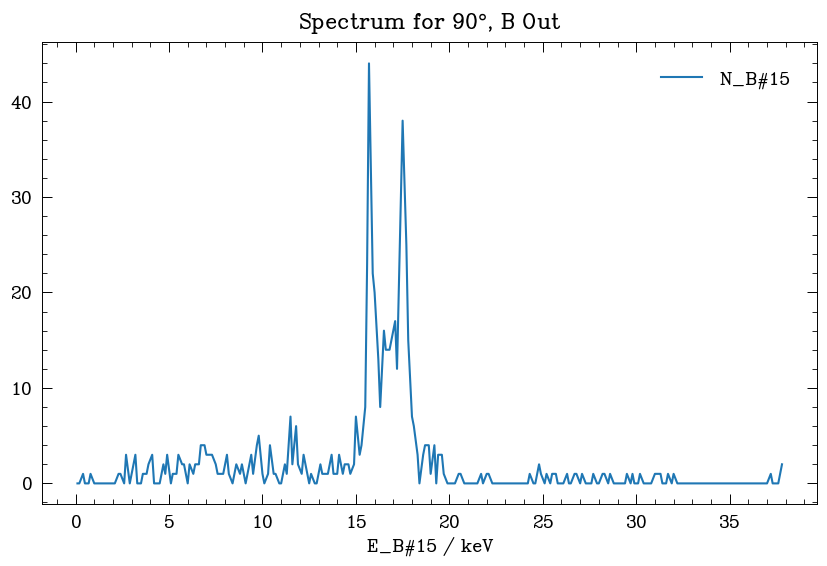

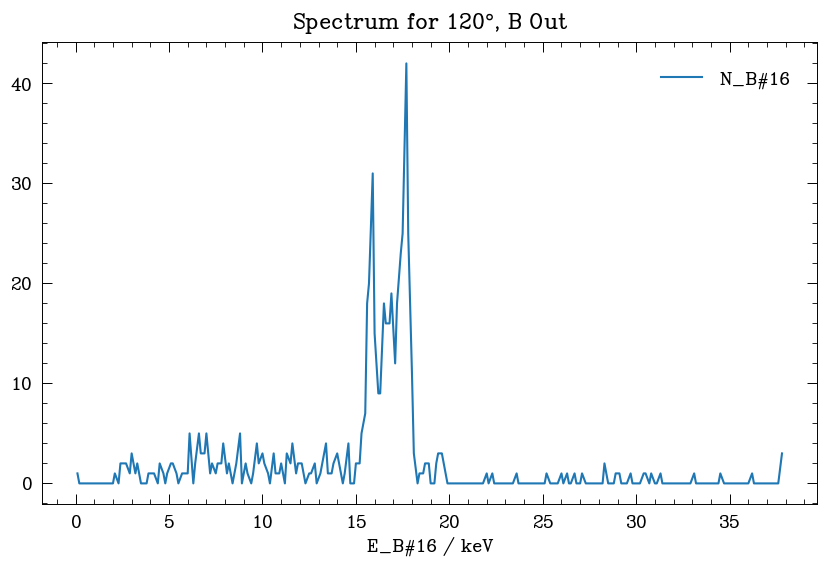

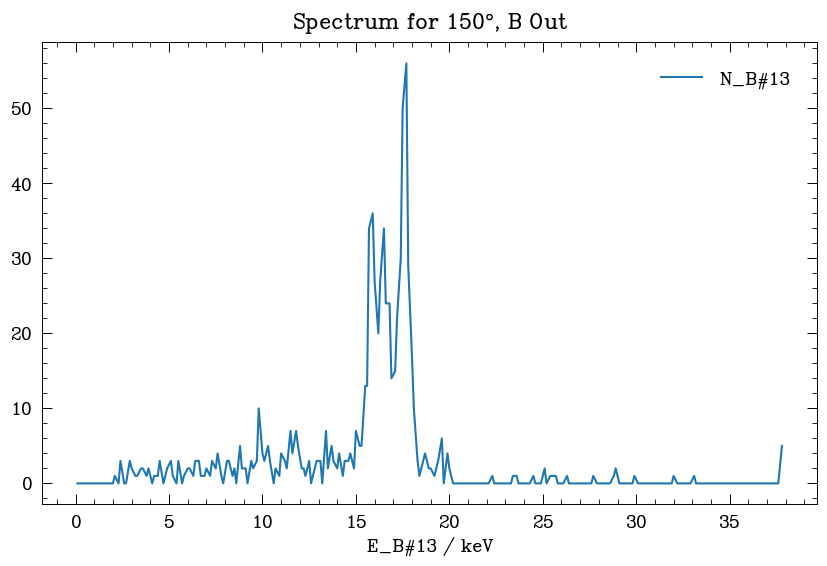

In [23]:
import pandas as pd
import smplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

ns_bout = [30,60,90,120,150]

dfs_bout = {}

for n in ns_bout:
    df = pd.read_csv('Data/Cobalt/Zr Inc, Mo Detector, Olds Aperture/'+str(n)+'.txt', sep='\t')

    df.plot(x=0,y=1,figsize=(10,6))
    plt.title(r'Spectrum for $%d\degree$, B Out' % n)
    plt.show()
    dfs_bout[n] = df

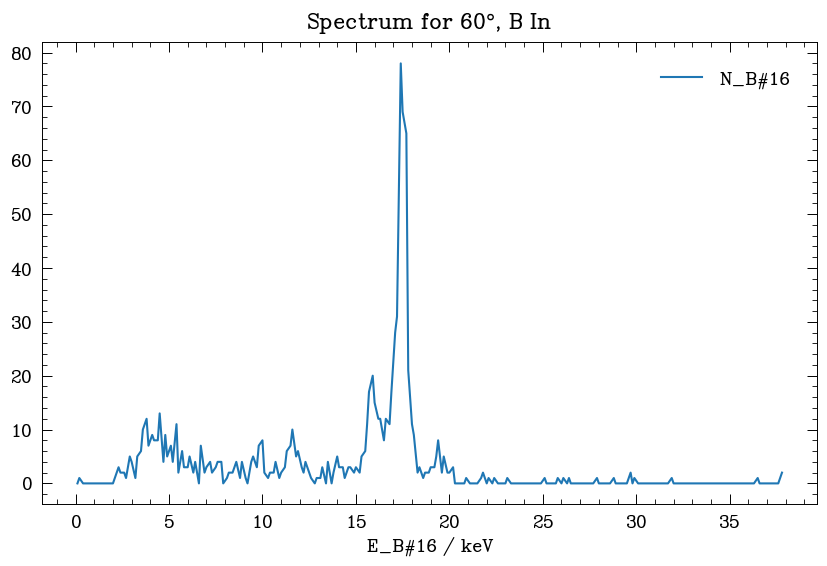

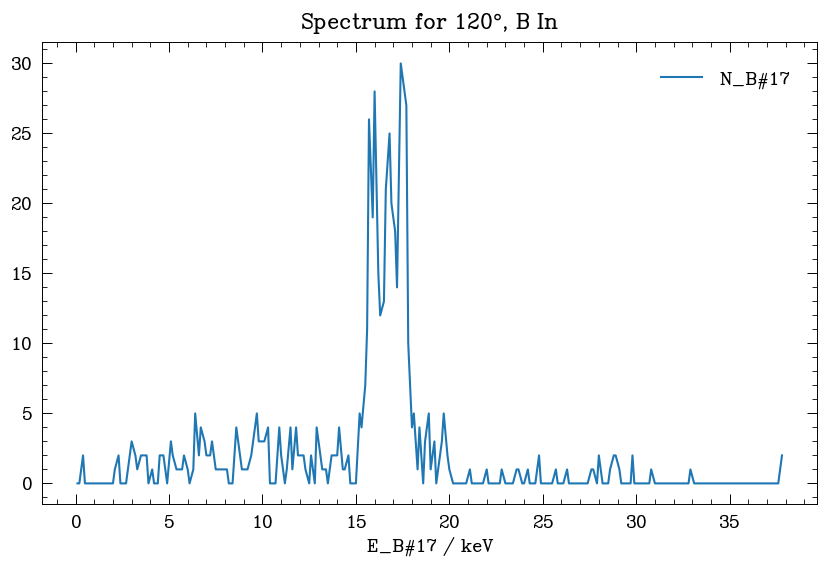

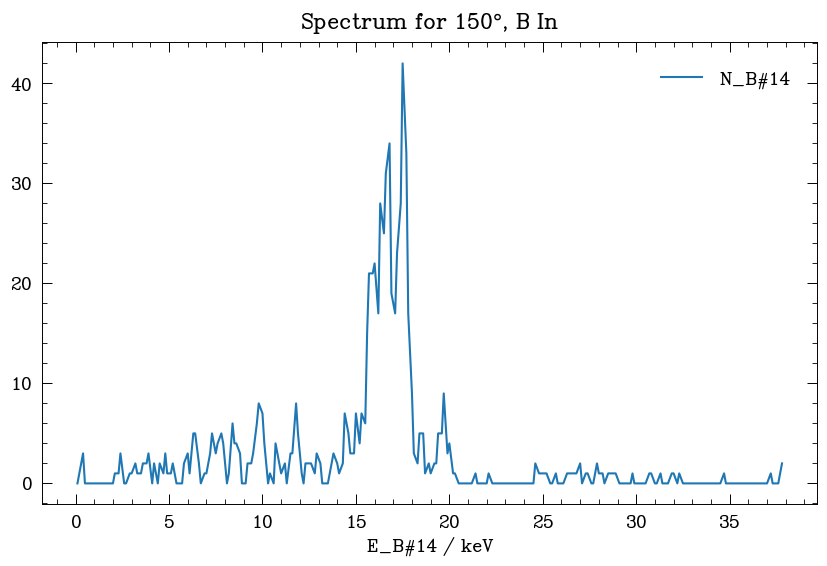

In [27]:
dfs_bin = {}

#The data is not in the .txt
ns_bin = [60,120,150]

for n in ns_bin:
    df = pd.read_csv('Data/Cobalt/Zr Inc, Mo Detector, Olds Aperture/B In/'+str(n)+'.txt', sep='\t')

    df.plot(x=0,y=1,figsize=(10,6))
    plt.title(r'Spectrum for $%d\degree$, B In' % n)
    plt.show()
    dfs_bin[n] = df

['Counts, Uncertainty\n', '452.000000, 9.303262\n', '332.000000, 8.803669\n', '412.000000, 9.318903\n']


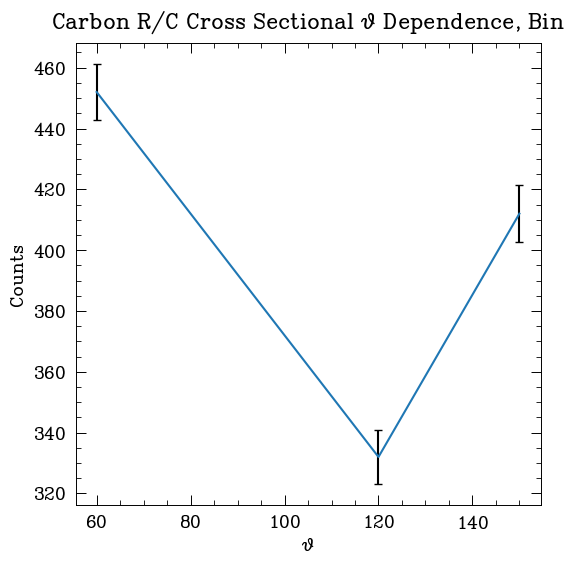

In [28]:
file_bin = open("Cobalt Cross Section Bin.txt", "w")

integrals_bin = []
errors_bin = []
peaks_bin = {}
lines = ['Counts, Uncertainty\n']
for n in ns_bin:
    Es = dfs_bin[n].iloc[:,0].to_numpy()
    counts = dfs_bin[n].iloc[:,1].to_numpy()
    
    peaks = []
    Epeaks = []
    for i,E in enumerate(Es):
        #bounds for peaks
        if E > 15.5 and E < 18.5:
            peaks.append(counts[i])
            Epeaks.append(E)
    peaks = np.array(peaks)
    peaks_bin[n] = peaks,Epeaks
    errors_bin.append(np.sqrt(np.sum(np.sqrt(peaks))))
    integrals_bin.append(peaks.sum())
    lines.append('%f, %f\n' % (integrals_bin[-1],errors_bin[-1]))
        
file_bin.writelines(lines)
file_bin.close()
print(lines)
    
plt.errorbar(ns_in,integrals_bin,yerr=errors_bin,ecolor='black')
plt.xlabel(r'$\theta$')
plt.ylabel('Counts')
plt.title(r'Carbon R/C Cross Sectional $\theta$ Dependence, Bin')
plt.show()        

['Counts, Uncertainty\n', '864.000000, 10.389328\n', '529.000000, 9.588250\n', '341.000000, 8.787433\n', '331.000000, 8.705691\n', '486.000000, 9.678281\n']


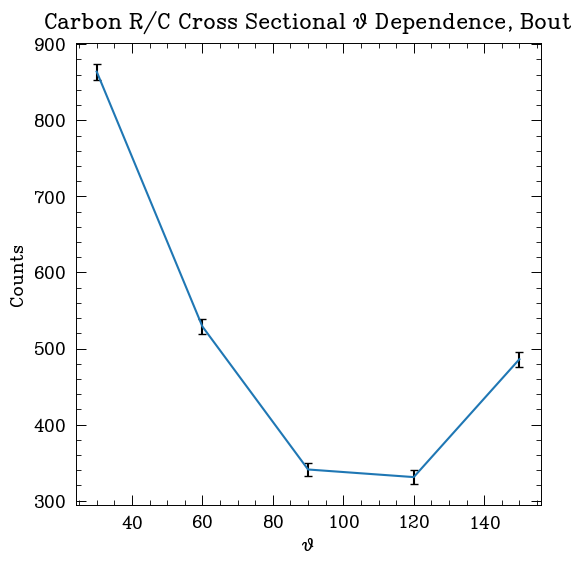

In [25]:
file_bout = open("Cobalt Cross Section Bin.txt", "w")

integrals_bout = []
errors_bout = []
peaks_bout = {}
lines = ['Counts, Uncertainty\n']
for n in ns_out:
    Es = dfs_bout[n].iloc[:,0].to_numpy()
    counts = dfs_bout[n].iloc[:,1].to_numpy()
    
    peaks = []
    Epeaks = []
    for i,E in enumerate(Es):
        #bounds for peaks
        if E > 15.5 and E < 18.5:
            peaks.append(counts[i])
            Epeaks.append(E)
    peaks = np.array(peaks)
    peaks_bout[n] = peaks,Epeaks
    errors_bout.append(np.sqrt(np.sum(np.sqrt(peaks))))
    integrals_bout.append(peaks.sum())
    lines.append('%f, %f\n' % (integrals_bout[-1],errors_bout[-1]))
        
file_bout.writelines(lines)
file_bout.close()
print(lines)
    
plt.errorbar(ns_bout,integrals_bout,yerr=errors_bout,ecolor='black')
plt.xlabel(r'$\theta$')
plt.ylabel('Counts')
plt.title(r'Carbon R/C Cross Sectional $\theta$ Dependence, Bout')
plt.show()        

In [35]:
import scipy as sp

def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

m_e = 511
kA_Mo = 17.479372

def compton_shift(theta, E_0):
    return E_0/(1+E_0/m_e*(1-np.cos(np.pi/180*theta)))

def red_chi_2(f,y,y_err):
    return np.sum(((y-f)**2)/(y_err**2))/len(y)

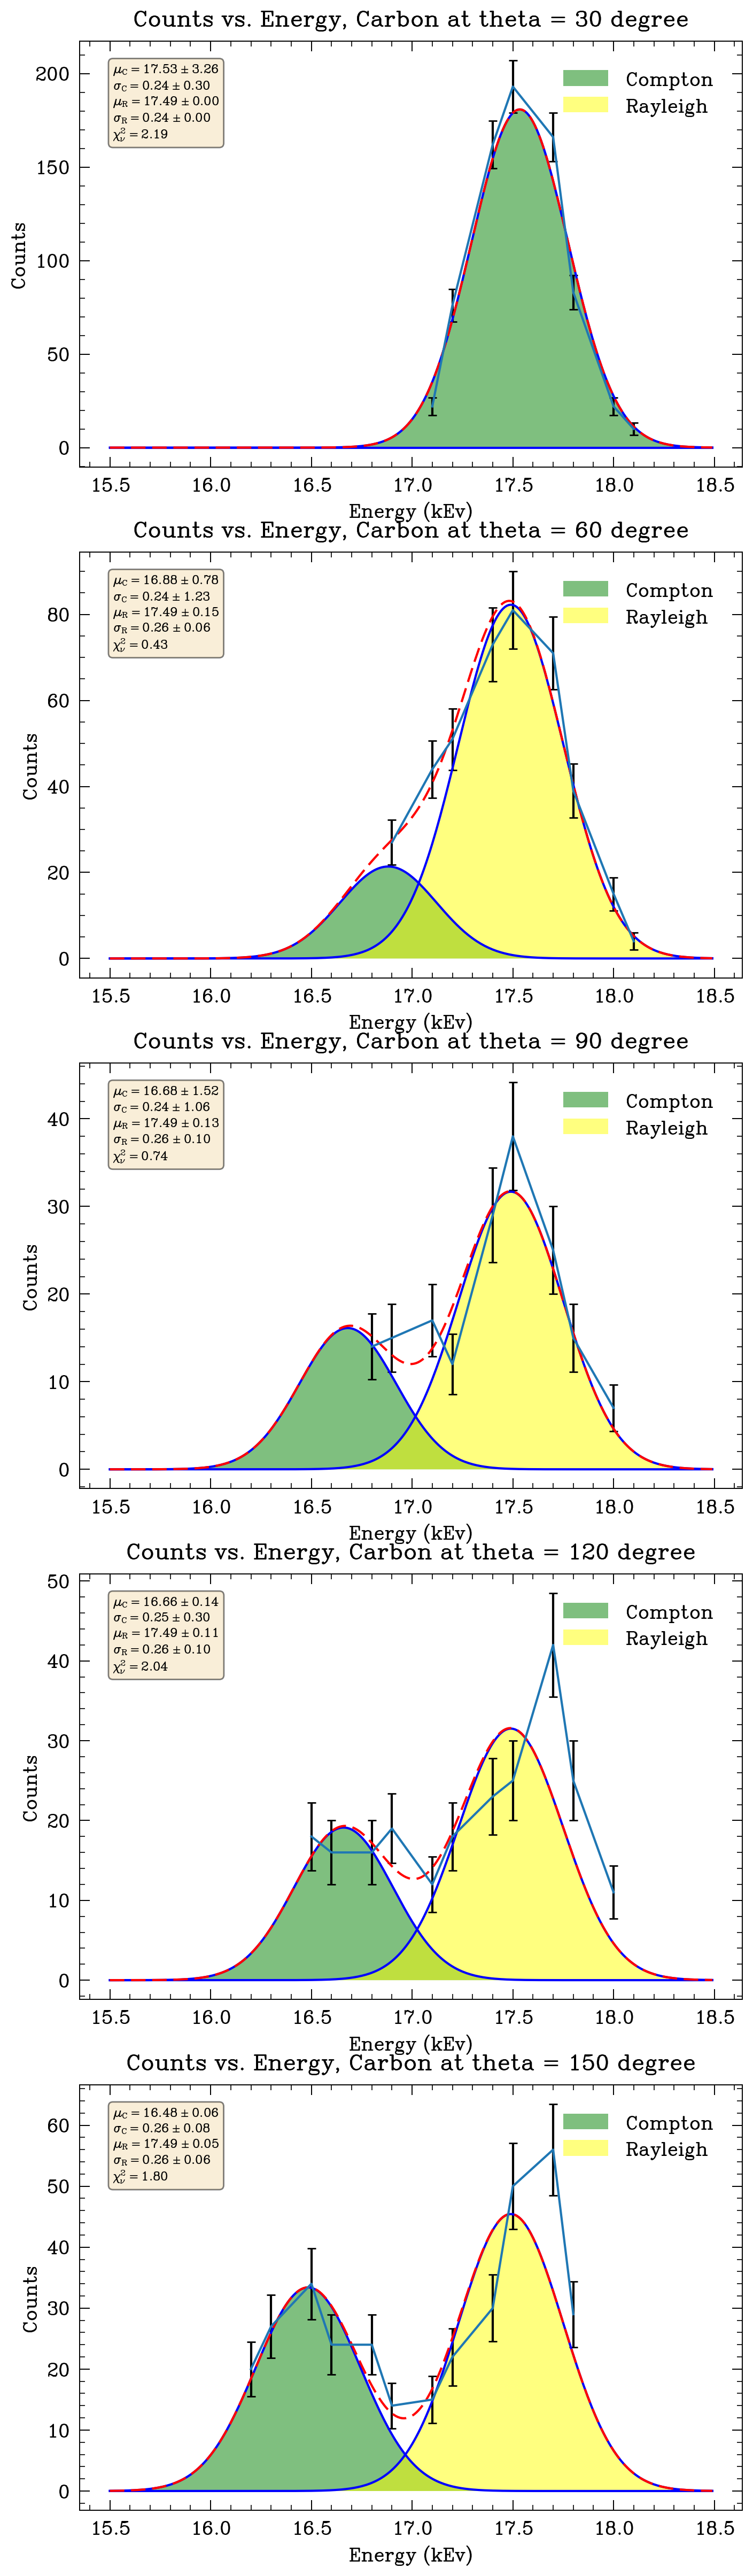

In [42]:
pars_bout = {}
perrs_bout = {}

ptrim_bout = [
    #30
    [10,1],
    #60
    [9,1],
    #90
    [8,2],
    #120
    [6,2],
    #150
    [4,3]
]
ptrim_bout = dict(zip(ns_bout, ptrim_bout))
peaks_bout_modified = {}

fig,ax = plt.subplots(len(ns),figsize=(8,6*len(ns)),dpi=200)

for j,n in enumerate(ns_bout):
    peaks,Es = peaks_bout[n]
    Es = np.array(Es)[ptrim_bout[n][0]:-ptrim_bout[n][1]-1]
    peaks = np.array(peaks)[ptrim_bout[n][0]:-ptrim_bout[n][1]-1]
    peaks_bout_modified[n] = peaks,Es
    amp1 = 500*(1+np.cos(n*np.pi/180)**2)/2
    cen1 = compton_shift(n, kA_Mo)
    sigma1 = 0.25
    
    if n > 5:
        amp2 = amp1
        cen2 = 17.48
        sigma2 = sigma1
        
        bounds = ([0,cen1-0.5,sigma1-0.01,0,cen2-0.01,sigma2-0.01],[1000,cen1+0.5,sigma1+0.01,1000,cen2+0.01,sigma2+0.01])
        
        popt_2gauss, pcov_2gauss = sp.optimize.curve_fit(_2gaussian, Es, peaks, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2],sigma=np.sqrt(peaks),bounds = bounds)
        perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
        pars_1 = popt_2gauss[0:3]
        perr_1 = perr_2gauss[0:3]
        pars_2 = popt_2gauss[3:6]
        perr_2 = perr_2gauss[3:6]
        gauss_peak_1 = _1gaussian(np.arange(15.5,18.5,0.01), *pars_1)
        gauss_peak_2 = _1gaussian(np.arange(15.5,18.5,0.01), *pars_2)
    
        pars_bout[n] = popt_2gauss
        perrs_bout[n] = perr_2gauss
    
        mu1 = pars_1[1]
        muE1 = perr_1[1]
        sigma1 = pars_1[2]
        sigmaE1 = perr_1[2]
        mu2 = pars_2[1]
        muE2 = perr_2[1]
        sigma2 = pars_2[2]
        sigmaE2 = perr_2[2]
        
        chi = red_chi_2(_1gaussian(Es, *pars_2)+_1gaussian(Es, *pars_1),peaks,np.sqrt(peaks))
        
        textstr = '\n'.join((
            r'$\mu_C=%.2f\pm%.2f$' % (mu1, muE1),
            r'$\sigma_C=%.2f\pm%.2f$' % (sigma1, sigmaE1),
            r'$\mu_R=%.2f\pm%.2f$' % (mu2, muE2),
            r'$\sigma_R=%.2f\pm%.2f$' % (sigma2, sigmaE2),
            r'$\chi^2_{\nu}=%.2f$' % (chi, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax[j].text(0.05, 0.95, textstr, transform=ax[j].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
    
        ax[j].errorbar(Es,peaks,yerr=np.sqrt(peaks),ecolor='black')
        ax[j].plot(np.arange(15.5,18.5,0.01),gauss_peak_1,'b-')
        ax[j].plot(np.arange(15.5,18.5,0.01),gauss_peak_2,'b-')
        ax[j].plot(np.arange(15.5,18.5,0.01),gauss_peak_1+gauss_peak_2,'r--')
        ax[j].fill_between(np.arange(15.5,18.5,0.01), gauss_peak_1.min(), gauss_peak_1, facecolor="green",label='Compton', alpha=0.5) 
        ax[j].fill_between(np.arange(15.5,18.5,0.01), gauss_peak_2.min(), gauss_peak_2, facecolor="yellow",label='Rayleigh', alpha=0.5) 
        ax[j].set_title('Counts vs. Energy, Carbon at theta = %d degree' % n)
        ax[j].set_xlabel('Energy (kEv)')
        ax[j].set_ylabel('Counts')
        ax[j].legend(loc='upper right')
    """
    else:
        popt_gauss, pcov_gauss = sp.optimize.curve_fit(_1gaussian, Es, peaks, p0=[amp1, cen1, sigma1],sigma=np.sqrt(peaks))
        perr_gauss = np.sqrt(np.diag(pcov_gauss))
        gauss_peak = _1gaussian(np.arange(15.5,18.5,0.01), *popt_gauss)
        
        pars[n] = popt_gauss
        perrs[n] = perr_gauss

        mu = popt_gauss[1]
        muE = perr_gauss[1]
        sigma = popt_gauss[2]
        sigmaE = perr_gauss[2]
        
        chi = red_chi_2(_1gaussian(Es, *popt_gauss),peaks,np.sqrt(peaks))
        
        textstr = '\n'.join((
            r'$\mu=%.2f\pm%.2f$' % (mu, muE),
            r'$\sigma=%.2f\pm%.2f$' % (sigma, sigmaE),
            r'$\chi^2_{\nu}=%.2f$' % (chi, )))

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
        
        plt.errorbar(Es,peaks,yerr=np.sqrt(peaks),ecolor='black')
        plt.plot(np.arange(15.5,18.5,0.01),gauss_peak,'b-')
        plt.fill_between(np.arange(15.5,18.5,0.01), gauss_peak.min(), gauss_peak, facecolor="green", alpha=0.5)
        plt.title(r'Counts vs. Energy, Carbon at $\theta = %d \degree$' % n)
        plt.xlabel('Energy (kEv)')
        plt.ylabel('Counts')
        plt.show()  
   """   
    
plt.show() 

734
0.24000000000000002
0.45
405
0.24000000000000168
0.45
172
0.24000000000000027
0.45
225
0.246084761694537
0.13828018344490495
345
0.25999999999999995
0.06252294031819935
['Theta, Counts, Uncertainty\n', '30.000000, 734.000000, 27.092434\n', '60.000000, 405.000000, 20.124612\n', '90.000000, 172.000000, 13.114877\n', '120.000000, 225.000000, 15.000000\n', '150.000000, 345.000000, 18.574176\n']


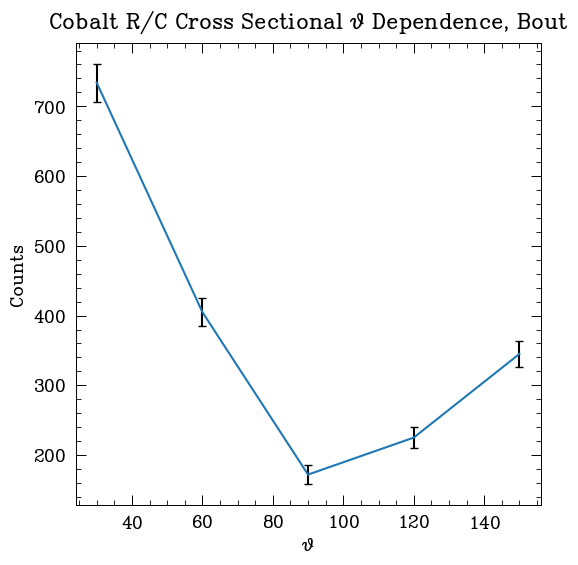

In [46]:
mus_bout = {}
sigmas_bout = {}
SDMs_bout = {}

#fileC = open("Carbon Cross Section.txt", "w")

lines = ['Theta, Counts, Uncertainty\n']

integrals_bout = []
errors_bout = []

for n in ns_bout:
    mu1 = pars_bout[n][1]
    mu1_unc = perrs_bout[n][1]
    sigma1 = pars_bout[n][2]
    sigma1_unc = perrs_bout[n][2]
    peaks,Es = peaks_bout_modified[n]
    N = np.sum(peaks)
    print(N)
    print(sigma1)
    SDM = (sigma1)/np.sqrt(N)
    mus_bout[n] = mu1
    sigmas_bout[n] = sigma1
    SDMs_bout[n] = min(mu1_unc,0.45)
    print(SDMs_bout[n])
    lines.append('%f, %f, %f\n' % (n,N,np.sqrt(N)))
    integrals_bout.append(N)
    errors_bout.append(np.sqrt(N))
    
#fileC.writelines(lines)
#fileC.close()
print(lines)
    
plt.errorbar(ns,integrals_bout,yerr=errors_bout,ecolor='black')
plt.xlabel(r'$\theta$')
plt.ylabel('Counts')
plt.title(r'Cobalt R/C Cross Sectional $\theta$ Dependence, Bout')
plt.show()

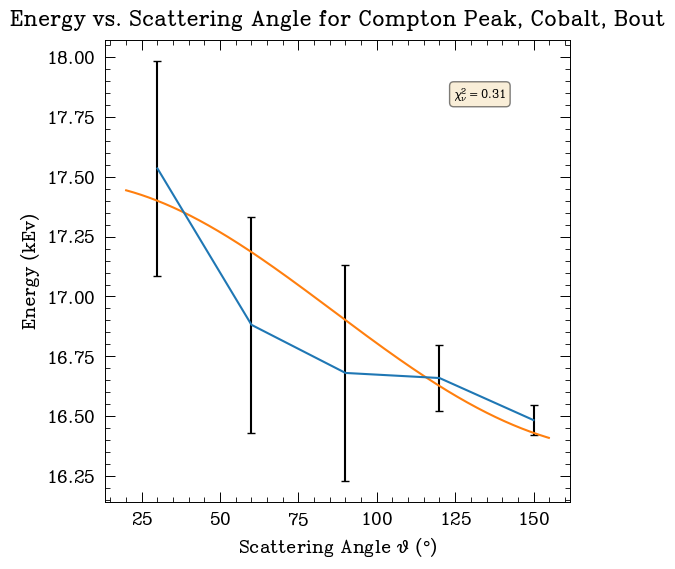

In [47]:
fig,ax = plt.subplots()
ax.errorbar(list(mus_bout.keys()),list(mus_bout.values()),yerr=list(SDMs_bout.values()),ecolor='black')
thetas = np.arange(20,155,0.1)
ax.plot(thetas,compton_shift(thetas, kA_Mo))

x = np.array(list(mus_bout.keys()))
f = compton_shift(x, kA_Mo)
y = np.array(list(mus_bout.values()))
y_err = np.array(list(SDMs_bout.values()))
chi = red_chi_2(f,y,y_err)

textstr = r'$\chi^2_{\nu}=%.2f$' % chi

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.75, 0.90, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.title('Energy vs. Scattering Angle for Compton Peak, Cobalt, Bout')
plt.xlabel(r'Scattering Angle $\theta$ ($\degree$)')
plt.ylabel('Energy (kEv)')
plt.show()